## Loading Financial Data

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
from datetime import timedelta

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler                # Scale the data between 0 and 1
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential

In [2]:
import pymysql
import mysql.connector

In [3]:
crypto_currency = 'DOGE'
against_currency = 'USD'

In [4]:
start = dt.datetime(2015,1,1)
end = dt.datetime.now()

In [5]:
data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end)

In [6]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-11-09,0.001415,0.001181,0.001207,0.001415,6259550,0.001415
2017-11-10,0.001431,0.001125,0.001421,0.001163,4246520,0.001163
2017-11-11,0.001257,0.001141,0.001146,0.001201,2231080,0.001201
2017-11-12,0.001210,0.001002,0.001189,0.001038,3288960,0.001038
2017-11-13,0.001212,0.001019,0.001046,0.001211,2481270,0.001211


## Data Preparation

In [7]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [8]:
# Number of days where the prediction is based on
prediction_days = 60
#future_day = 7

In [9]:
# Train Data
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)): # - future_day):
    x_train.append(scaled_data[x - prediction_days: x, 0])
    y_train.append(scaled_data[x, 0])  # + future_days

In [10]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Model Layers

In [11]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2)) 

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 25, batch_size = 32)

Epoch 1/25
50/50 [==============================] - 13s 63ms/step - loss: 0.0047
Epoch 2/25
50/50 [==============================] - 3s 60ms/step - loss: 0.0022
Epoch 3/25
50/50 [==============================] - 3s 59ms/step - loss: 0.0020
Epoch 4/25
50/50 [==============================] - 3s 60ms/step - loss: 0.0021
Epoch 5/25
50/50 [==============================] - 3s 60ms/step - loss: 0.0023
Epoch 6/25
50/50 [==============================] - 3s 59ms/step - loss: 0.0018
Epoch 7/25
50/50 [==============================] - 3s 59ms/step - loss: 0.0016
Epoch 8/25
50/50 [==============================] - 3s 60ms/step - loss: 0.0018
Epoch 9/25
50/50 [==============================] - 3s 61ms/step - loss: 0.0017
Epoch 10/25
50/50 [==============================] - 3s 60ms/step - loss: 0.0016
Epoch 11/25
50/50 [==============================] - 3s 60ms/step - loss: 0.0015
Epoch 12/25
50/50 [==============================] - 3s 59ms/step - loss: 0.0015
Epoch 13/25
50/50 [=================

## Testing the Model

In [12]:
test_start = dt.datetime(2017,1,1)   # Starts date of the data
test_end = dt.datetime.now()

test_data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

In [13]:
total_dataset = pd.concat((data['Close'], test_data['Close']), axis = 0)

In [14]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.fit_transform(model_inputs)

In [15]:
len(model_inputs)

1690

In [16]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [17]:
# Predict Prices
prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

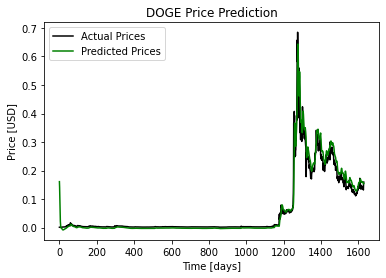

In [18]:
# Plotting
plt.plot(actual_prices, color = 'black', label = 'Actual Prices')
plt.plot(prediction_prices, color = 'green', label = 'Predicted Prices')
plt.title(f'{crypto_currency} Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price [USD]')
plt.legend(loc = 'upper left')
plt.show()

In [19]:
next_day_prediction = []

next_day_prediction = [(end + timedelta(1)).strftime('%Y-%m-%d'), prediction_prices[-1]]

print(next_day_prediction)

['2022-04-27', array([0.15556327], dtype=float32)]
